Since we're with enough amount of data, our main Data Augmentation objective is not to overcome overfitting. These RAVDEES and CREMA datasets are artificially created in studio by professional actors, who performs different emotions by repeated utterances.

So, these Audio samples free from background noise. But its not resembles real world scenerios, where data can feed into our model with noise. So, we have to teach our model with noisy data too. Then it could generalises well.

Like Image Augmentation, Audio signals also having some well known augmentation process Like. Here Iam augmenting audio using below listed process.


*   Noise Injection
*   Changing Pitch

*   Changing Speed


**Data augmentation cannot replace real training data. It just help to generate synthetic data to make the model better.**

In [78]:
# Import dependencies
# for audio processing
import librosa
import librosa.display

# for algeberic functions and analytical framework
import numpy as np
import pandas as pd

# for vizualisation
import seaborn as sns
import matplotlib.pyplot as plt

# for data processsing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# for model building
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout
from keras.layers import Input, Flatten, Dropout, Activation,BatchNormalization, Dense

# for model evaluating
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# To play sound in the notebook
import IPython.display as ipd  
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

##### LOADING PROCESSED DATASET:

In [11]:
original_df = pd.concat([pd.read_csv('features/Ravdees_df.csv'),
                         pd.read_csv('features/crema_df.csv')],axis=0,ignore_index=True)
original_df.drop(['Unnamed: 0'],axis=1,inplace=True)

original_df.head()

,path,Speaker,Emotion,Label
0,data\RAVDEES\Actor_01\03-01-01-01-01-01-01.wav,Men,neutral,Men_neutral
1,data\RAVDEES\Actor_01\03-01-01-01-01-02-01.wav,Men,neutral,Men_neutral
2,data\RAVDEES\Actor_01\03-01-01-01-02-01-01.wav,Men,neutral,Men_neutral
3,data\RAVDEES\Actor_01\03-01-01-01-02-02-01.wav,Men,neutral,Men_neutral
4,data\RAVDEES\Actor_01\03-01-02-01-01-01-01.wav,Men,calm,Men_calm


##### SHAPE:

In [9]:
original_df.shape

(10322, 4)

Initially pick a sample, and visialize how tranformation Intacts.

##### ORIGINAL:

In [12]:
# Pick a random track
raw_audio = original_df['path'][192]

'data\\RAVDEES\\Actor_04\\03-01-03-01-01-01-04.wav'

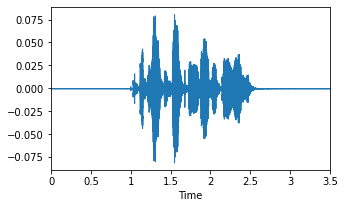

In [15]:
data, sampling_rate = librosa.load(raw_audio)
plt.figure(figsize=(5, 3))
librosa.display.waveplot(data, sr=sampling_rate)

# Paly it again to refresh our memory
ipd.Audio(data, rate=sampling_rate)

As contexed early, this utterance is completly clear and pretty much contradict to real world scenario.

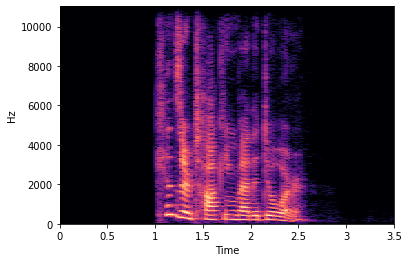

In [20]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')

**AFTER ADDING NOISE:**

There are two types of Noise we could add.


*   Adding White Gaussian Noise(AWGN)
*   Adding Real World Noise

Here we using AWGN method.

In [21]:
def noise(data):
    """
    Adding White Noise.
    """
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

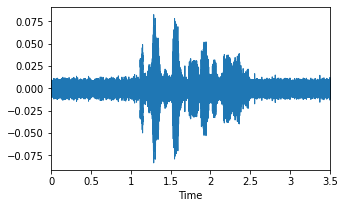

In [22]:
x = noise(data)
plt.figure(figsize=(5, 3))
librosa.display.waveplot(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

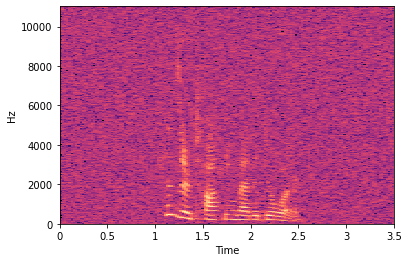

In [23]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')

**Audio Streching:**

Time stretching is the process of changing the speed or duration of an audio signal without affecting its pitch. Here we either speed up or slows down the audio signal. 

In [24]:
def stretch(data,rate):
    """
    Streching the Sound. Note that this expands the dataset slightly
    """
    if rate == 'speed':
      rate = 1.2
    else:
      rate = 0.8
    data = librosa.effects.time_stretch(data, rate)
    return data

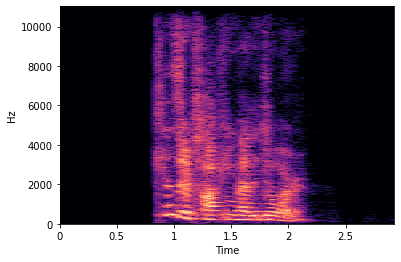

In [26]:
x_strech = stretch(data,rate='speed')
X = librosa.stft(x_strech)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
ipd.Audio(x_strech, rate=sampling_rate)

##### PITCH TUNING:

In [27]:
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      )
    return data

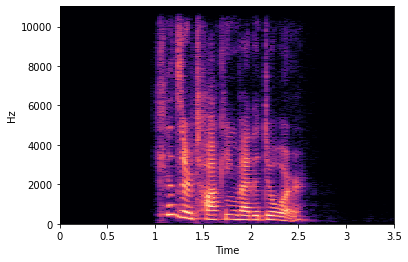

In [28]:
x_pitch = pitch(data,sampling_rate)
X = librosa.stft(x_pitch)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
ipd.Audio(x_pitch, rate=sampling_rate)

**COLLECTING SAMPLES:**

Here we are collecting some samples from dataset with respect to each category and apply augmentation.

In [31]:
X = original_df[['path','Speaker','Emotion']]

y = original_df['Label']

rest_x, want_x, rest_y, want_y = train_test_split(X,y, test_size=0.105, random_state=42,stratify=y)

want_x['Label'] = want_x['Speaker'] + '_' + want_x['Emotion']

In [33]:
def Augmentation(row,type):
    
    '''
    this function takes original data as input and returns transformed data
    '''
    features = []
    data, sample_rate = librosa.load(row)
    if type == 'noise':
        # adding background noise
        data_p = noise(data)
    if type == 'pitch':
        # transforming pitch
        data_p = pitch(data, sample_rate)
    if type == 'shift':
        # shifting signals over time
        data_p = shift(data)

    # extract mfcc from noisy data
    mfcc = librosa.feature.mfcc(y=data_p, sr=sample_rate,n_mfcc=13)
    mfccs_processed = np.mean(mfcc.T,axis=0)
    features.extend(mfccs_processed)

    # extract chroma feature from noisy data
    stft = np.abs(librosa.stft(data_p))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
    chroma_processed = np.mean(chroma.T,axis=0)
    features.extend(chroma_processed)

    # extract spectral contrast from noisy data
    spectral_contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate)
    spectral_contrast_processed = np.mean(spectral_contrast.T,axis=0)
    features.extend(spectral_contrast_processed)

    return features

##### ADDING NOISE:

In [34]:
want_x['features'] = want_x['path'].apply(Augmentation,type ='noise')

In [35]:
want_x_f = want_x['features'].apply(pd.Series)

Noise_df = pd.concat([want_x, want_x_f],axis=1)

In [37]:
# conctenating remaining dataset
rest = pd.concat([rest_x, rest_y],axis=1)
# assigning dependent & independent variable
X_2 = rest[['path','Speaker','Emotion']]
y_2 = rest['Label']
# train and test split
rest_x_2, want_x_2, rest_y_2, want_y_2 = train_test_split(X_2,y_2, test_size=0.12, random_state=42,stratify=y_2)
# creating labels
want_x_2['Label'] = want_x_2['Speaker'] + '_' + want_x_2['Emotion']
# augmenting pitch
want_x_2['features'] = want_x_2['path'].apply(Augmentation,type ='pitch')

In [38]:
want_x_2_f = want_x_2['features'].apply(pd.Series)

pitch_df = pd.concat([want_x_2, want_x_2_f],axis=1)

##### COMPILING:

In [41]:
Augmented_df = pd.concat([Noise_df, pitch_df],axis=0)
Augmented_df.drop(['features','path'], axis = 1,inplace=True)
Augmented_df.head()

,Speaker,Emotion,Label,0,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
2216,Men,surprised,Men_surprised,-387.227951,23.046764,2.168968,1.910963,-0.407077,-3.370884,-6.647360,...,0.767885,0.779145,0.768139,14.064028,12.133321,14.058933,13.825947,14.941952,14.100266,13.671310
7956,Women,disgust,Women_disgust,-294.573473,84.009015,14.817048,12.372013,6.050066,2.811734,-1.633225,...,0.686253,0.702233,0.649960,10.929128,14.140427,16.110339,15.398492,16.553526,15.499082,13.799169
9974,Men,neutral,Men_neutral,-307.050502,50.810315,34.740476,27.982208,16.862201,8.334155,2.877063,...,0.784580,0.777484,0.709366,17.440872,14.020314,16.431807,14.218965,14.312084,13.824086,13.602978
7699,Women,angry,Women_angry,-220.826611,43.271763,14.410626,21.420801,5.362642,-3.915354,-3.891500,...,0.710670,0.865524,0.789977,12.068819,16.203925,18.443007,15.301284,15.222034,14.907460,14.068731
9484,Men,angry,Men_angry,-92.544194,20.002221,3.818736,-1.119789,-1.068297,-3.229388,-4.718358,...,0.757725,0.796461,0.783969,13.977711,12.554064,14.867469,13.786948,14.109426,13.517244,13.664972


In [44]:
Augmented_df.replace(to_replace ="calm",
                 value ="neutral",inplace=True)

Augmented_df = Augmented_df[Augmented_df['Emotion'] != 'surprised']

In [45]:
# save for further usage
Augmented_df.to_csv('Augmented_df.csv')

##### MODEL TRAINING:

In [53]:
AUDIO_df = pd.read_csv('features/AUDIO_DF.csv')
AUDIO_df.drop(['Unnamed: 0','Speaker','Emotion'],axis=1,inplace=True)

Augmented_df = pd.read_csv('features/Augmented_df.csv')
Augmented_df.drop(['Unnamed: 0','Speaker','Emotion'],axis=1,inplace=True)

In [56]:
complete_df = pd.DataFrame(np.concatenate([AUDIO_df.values,Augmented_df.values],axis=0))
complete_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Men_neutral,-697.9842,55.22849,0.323863,12.775377,7.396147,0.866224,-3.550276,-2.828331,-11.305532,...,0.7463,0.744283,0.722983,19.170998,11.228536,14.938287,14.187339,14.899156,16.857357,29.403947
1,Men_neutral,-693.06976,55.73457,-1.919739,16.408995,8.449355,0.220736,-1.738342,-4.931291,-11.981821,...,0.741526,0.739967,0.722161,19.703677,12.061533,15.659183,14.883159,15.174847,16.912811,28.869441
2,Men_neutral,-691.77014,58.350647,-0.16516,13.952125,5.053323,1.489326,-2.397429,-5.059065,-10.638003,...,0.754845,0.70465,0.713902,18.818881,12.208414,14.876291,14.282521,15.448914,16.767068,29.213471
3,Men_neutral,-685.2379,56.236694,2.453112,13.566656,6.701949,3.341493,-1.895052,-6.673817,-10.671633,...,0.708235,0.719849,0.735221,20.481934,11.763805,15.675734,15.455351,15.378251,16.154742,28.362977
4,Men_calm,-727.31793,62.7644,2.751275,15.473256,7.763115,2.330714,-3.641682,-3.367344,-10.113077,...,0.737612,0.769464,0.702859,18.478177,11.24641,15.137288,14.289477,15.609332,16.297521,28.978391


In [79]:
complete_df.to_csv('rawaug.csv')

In [58]:
dependent_variable = 0

Independent_variable = set(complete_df.columns.to_list()) - {dependent_variable}

In [59]:
X_train, X_test, y_train, y_test = train_test_split(complete_df[Independent_variable],complete_df[dependent_variable], 
                                                    test_size=0.20, random_state=43,stratify=complete_df[dependent_variable])

In [61]:
normalizer = StandardScaler()

In [62]:
# normalizing train data points
X_train = normalizer.fit_transform(X_train.values) 

# normalizing valid data points
X_test = normalizer.transform(X_test.values)

In [63]:
# one hot encode the target 
lb = LabelEncoder()

# train set target encoding
y_train = to_categorical(lb.fit_transform(y_train))

# test target encoding
y_test = to_categorical(lb.fit_transform(y_test))

In [67]:
# initiate sequence
def tuned_model():
  num_hidden_layers = 3
  model = tf.keras.models.Sequential()
  # input layer
  model.add(tf.keras.layers.Dense(60, input_dim = 32 , activation = 'relu'))

  for i in range(0, num_hidden_layers):
    # fully connected layer
    model.add(tf.keras.layers.Dense(60))
    # batch Normalization
    model.add(tf.keras.layers.BatchNormalization())
    # Activation Layer
    model.add(tf.keras.layers.Activation(activation='relu'))
    # Dropout Layer
    model.add(tf.keras.layers.Dropout(0.35))
  # Output Layer
  model.add(tf.keras.layers.Dense(14, activation = 'softmax'))
  # model compliling
  model.compile(
      loss = 'categorical_crossentropy',
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.0076),
      metrics = ['accuracy']
  )

  return model

In [68]:
DNN_model = tuned_model()

In [69]:
model_tracing = DNN_model.fit(X_train, y_train, epochs = 100, batch_size = 32,validation_data=(X_test, y_test))

Epoch 1/100
302/302 [==============================] - 10s 10ms/step - loss: 2.2811 - accuracy: 0.1969 - val_loss: 1.8978 - val_accuracy: 0.2946
Epoch 2/100
302/302 [==============================] - 2s 7ms/step - loss: 1.9815 - accuracy: 0.2716 - val_loss: 1.7842 - val_accuracy: 0.3315
Epoch 3/100
302/302 [==============================] - 3s 8ms/step - loss: 1.9146 - accuracy: 0.2907 - val_loss: 1.7749 - val_accuracy: 0.3174
Epoch 4/100
302/302 [==============================] - 2s 8ms/step - loss: 1.8852 - accuracy: 0.2996 - val_loss: 1.6912 - val_accuracy: 0.3506
Epoch 5/100
302/302 [==============================] - 2s 8ms/step - loss: 1.8412 - accuracy: 0.3151 - val_loss: 1.6938 - val_accuracy: 0.3589
Epoch 6/100
302/302 [==============================] - 2s 8ms/step - loss: 1.8372 - accuracy: 0.3172 - val_loss: 1.6739 - val_accuracy: 0.3539
Epoch 7/100
302/302 [==============================] - 2s 8ms/step - loss: 1.8070 - accuracy: 0.3232 - val_loss: 1.6576 - val_accuracy: 0.36

Epoch 58/100
302/302 [==============================] - 2s 7ms/step - loss: 1.4971 - accuracy: 0.4511 - val_loss: 1.4576 - val_accuracy: 0.4585
Epoch 59/100
302/302 [==============================] - 2s 7ms/step - loss: 1.4800 - accuracy: 0.4635 - val_loss: 1.4543 - val_accuracy: 0.4697
Epoch 60/100
302/302 [==============================] - 2s 7ms/step - loss: 1.4951 - accuracy: 0.4482 - val_loss: 1.4507 - val_accuracy: 0.4618
Epoch 61/100
302/302 [==============================] - 2s 8ms/step - loss: 1.4791 - accuracy: 0.4589 - val_loss: 1.4610 - val_accuracy: 0.4560
Epoch 62/100
302/302 [==============================] - 2s 7ms/step - loss: 1.4904 - accuracy: 0.4550 - val_loss: 1.4661 - val_accuracy: 0.4627
Epoch 63/100
302/302 [==============================] - 2s 7ms/step - loss: 1.4872 - accuracy: 0.4433 - val_loss: 1.4486 - val_accuracy: 0.4643
Epoch 64/100
302/302 [==============================] - 2s 7ms/step - loss: 1.4914 - accuracy: 0.4584 - val_loss: 1.4667 - val_accuracy:

In [73]:
def F1_Score(y_true, y_pred,class_names):
  test_keys = class_names.tolist()
  test_values = f1_score(y_true, y_pred,average=None).tolist()
  res = {'labels' :test_keys, 'F1_score' : test_values}
  df = pd.DataFrame.from_dict(res)
  fig, ax = plt.subplots(figsize = ( 15 , 7 ))
  ax = sns.barplot(x="labels", y="F1_score", data=df,palette='gist_earth_r')
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

  ax.axhline(y=df['F1_score'].min(), xmin=0.0, xmax=1.0, color='r',)
  ax.set_title( "F1_score_per_class" , size = 24 )

In [71]:
#Making prediction
y_pred=DNN_model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)

# true values
y_true=np.argmax(y_test,axis=1)

In [74]:
class_names = lb.classes_

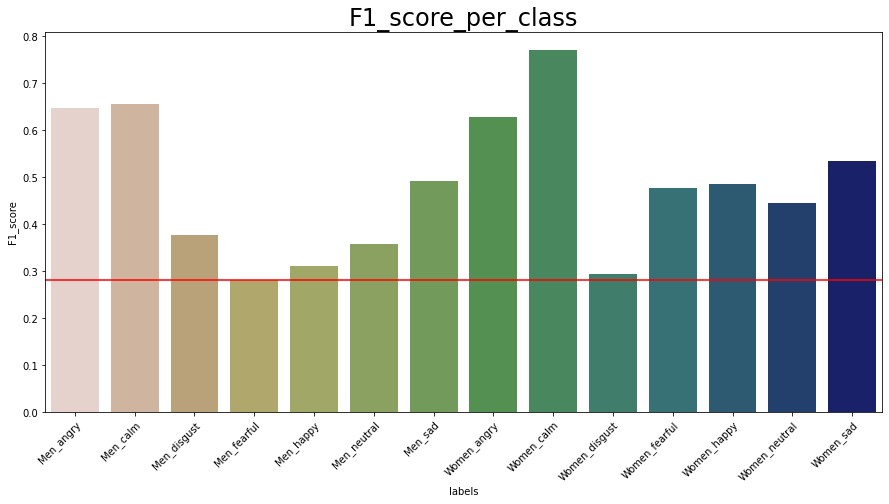

In [77]:
F1_Score(y_true, y_pred,class_names)